In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Tuple, Any, Union
from matplotlib.lines import Line2D
from sklearn.metrics.pairwise import cosine_similarity
from glob import glob
from scipy import sparse
from tqdm.auto import tqdm
from scipy.stats import spearmanr
# kl divergence
from scipy.special import kl_div
import seaborn as sns

In [3]:
def plot_subreddits(all_subreddits: pd.DataFrame, subreddits: List[str]):
    BG_WHITE = "#fbf9f4"
    BLUE = "#2a475e"
    GREY70 = "#b3b3b3"
    GREY_LIGHT = "#f2efe8"
    COLORS = ["#FF5A5F", "#FFB400", "#007A87", "#5d2e46", "#323031"]
    SHAPES = ["o", "s", "v", "D", "X"]

    assert len(subreddits) <= 5, "Only 5 subreddits are supported"
    # The four variables in the plot
    VARIABLES = all_subreddits.loc[subreddits[0]].index.tolist()
    VARIABLES_N = len(VARIABLES)

    # The angles at which the values of the numeric variables are placed
    ANGLES = [n / VARIABLES_N * 2 * np.pi for n in range(VARIABLES_N)]
    ANGLES += ANGLES[:1]

    # Padding used to customize the location of the tick labels
    X_VERTICAL_TICK_PADDING = 5
    X_HORIZONTAL_TICK_PADDING = 50    

    # Angle values going from 0 to 2*pi
    HANGLES = np.linspace(0, 2 * np.pi)

    # Used for the equivalent of horizontal lines in cartesian coordinates plots 
    # The last one is also used to add a fill which acts a background color.
    H0 = np.zeros(len(HANGLES))
    H1 = np.ones(len(HANGLES)) * 0.5
    H2 = np.ones(len(HANGLES))
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, polar=True)

    fig.patch.set_facecolor(BG_WHITE)
    _ = ax.set_facecolor(BG_WHITE)

    # Rotate the "" 0 degrees on top. 
    # There it where the first variable, avg_bill_length, will go.
    _ = ax.set_theta_offset(np.pi / 2)
    _ = ax.set_theta_direction(-1)

    # Setting lower limit to negative value reduces overlap
    # for values that are 0 (the minimums)
    _ = ax.set_ylim(-0.1, 1.05)

    # Plot lines and dots --------------------------------------------
    for idx, subreddit in enumerate(subreddits):
        subreddit_values = all_subreddits.loc[subreddit]
        radar_values = [subreddit_values[v] for v in VARIABLES]
        radar_values += radar_values[:1]
        ax.plot(ANGLES, radar_values, c=COLORS[idx], linewidth=4, label=VARIABLES)
        ax.scatter(ANGLES, radar_values, s=160, c=COLORS[idx], zorder=10, marker=SHAPES[idx])

    ax.set_xticks(ANGLES[:-1])
    ax.set_xticklabels(VARIABLES, size=20)

    # # Remove lines for radial axis (y)
    # ax.set_yticks([])
    # ax.yaxis.grid(False)
    # ax.xaxis.grid(False)

    # Remove spines
    ax.spines["start"].set_color("none")
    ax.spines["polar"].set_color("none")

    # Add custom lines for radial axis (y) at 0, 0.5 and 1.
    ax.plot(HANGLES, H0, ls=(0, (6, 6)), c=GREY70)
    ax.plot(HANGLES, H1, ls=(0, (6, 6)), c=COLORS[2])
    ax.plot(HANGLES, H2, ls=(0, (6, 6)), c=GREY70)

    # Now fill the area of the circle with radius 1.
    # This create the effect of gray background.
    ax.fill(HANGLES, H2, GREY_LIGHT)

    # # Custom guides for angular axis (x).
    # # These four lines do not cross the y = 0 value, so they go from 
    # # the innermost circle, to the outermost circle with radius 1.
    # ax.plot([0, 0], [0, 1], lw=2, c=GREY70)
    # ax.plot([np.pi, np.pi], [0, 1], lw=2, c=GREY70)
    # ax.plot([np.pi / 2, np.pi / 2], [0, 1], lw=2, c=GREY70)
    # ax.plot([-np.pi / 2, -np.pi / 2], [0, 1], lw=2, c=GREY70)

    # Add levels -----------------------------------------------------
    # These labels indicate the values of the radial axis
    PAD = 0.05
    ax.text(-0.4, 0 + PAD, "0%", size=16)
    ax.text(-0.4, 0.5 + PAD, "50%", size=16)
    ax.text(-0.4, 1 + PAD, "100%", size=16)

    # Iterate through species names and colors.
    # These handles contain both markers and lines.
    handles = [
        Line2D(
            [], [], 
            c=color, 
            lw=3, 
            marker=shape, 
            markersize=8, 
            label=sub
        )
        for sub, color, shape in zip(subreddits, COLORS, SHAPES)
    ]

    legend = ax.legend(
        handles=handles,
        loc=(1, 0),       # bottom-right
        labelspacing=1.5, # add space between labels
        frameon=False     # don't put a frame
    )

    # Iterate through text elements and change their properties
    for text in legend.get_texts():
        text.set_fontsize(18) 
        
    return fig      

def find_most_similar_subreddits(all_subreddits: pd.DataFrame, subreddit: str, n: int = 3):
    subreddit_values = all_subreddits.loc[subreddit]
    subreddit_values = subreddit_values.values.reshape(1, -1)
    similarities = cosine_similarity(all_subreddits, subreddit_values)
    similarities = similarities.flatten()
    similarities = similarities.argsort()[::-1]
    similarities = similarities[1:n+1]
    most_similar = all_subreddits.iloc[similarities].index.tolist()
    return most_similar 

def find_least_similar_subreddits(all_subreddits: pd.DataFrame, subreddit: str, n: int = 3):
    subreddit_values = all_subreddits.loc[subreddit]
    subreddit_values = subreddit_values.values.reshape(1, -1)
    similarities = cosine_similarity(all_subreddits, subreddit_values)
    similarities = similarities.flatten()
    similarities = similarities.argsort()
    similarities = similarities[0:n]
    most_similar = all_subreddits.iloc[similarities].index.tolist()
    return most_similar 

def calc_user_similaity(sub_1, sub_2, index, matrix):
    return matrix[index[sub_1], index[sub_2]]

def calc_value_similarity(sub_1, sub_2, all_subreddits, method="cosine"):
    subreddit_values_1 = all_subreddits.loc[sub_1].values
    subreddit_values_2 = all_subreddits.loc[sub_2].values
    if method == "kl":
        return kl_div(subreddit_values_1, subreddit_values_2)
    elif method == "cosine":
        return cosine_similarity(subreddit_values_1.reshape(1, -1), subreddit_values_2.reshape(1, -1))[0][0]

def calc_similarity_matrix(all_subreddits):
    similarity_matrix = np.zeros((len(all_subreddits), len(all_subreddits)))
    values = np.array(all_subreddits.values.tolist())
    similarity_matrix = cosine_similarity(values)
    return similarity_matrix

def normalise_values(subreddit_data: pd.DataFrame):
    average_values = subreddit_data.mean(axis=0)
    value_divergance = subreddit_data.apply(lambda x: x - average_values, axis=1)

    min_divergance = value_divergance.min(axis=0)
    max_divergance = value_divergance.max(axis=0) 
    max_minus_min = max_divergance - min_divergance

    mormalized_divergance = value_divergance.apply(lambda x: x - min_divergance, axis=1)
    normalized_divergance = mormalized_divergance.apply(lambda x: x / max_minus_min, axis=1)

    sum_values_per_subreddit = normalized_divergance.sum(axis=1)
    normalised_sum_to_one = normalized_divergance.apply(lambda x: x / sum_values_per_subreddit, axis=0)

    return normalized_divergance, normalised_sum_to_one, value_divergance

In [4]:
subreddit_data = pd.read_csv("outputs/1000_posts_refined_unnormalised_values.csv", index_col=0)
subreddit_data = subreddit_data.reset_index()
subreddit_data = subreddit_data.rename(columns={"Unnamed: 0": "subreddit"})
subreddit_data = subreddit_data.set_index("subreddit")
subreddit_data_with_meta = subreddit_data.copy()
subreddit_data = subreddit_data[["achievement", "benevolence",	"conformity", "hedonism", "power", "security", "self-direction", "stimulation",	"tradition", "universalism"]]
normalized_divergance, normalised_sum_to_one, value_divergance = normalise_values(subreddit_data)

cols_to_use = subreddit_data_with_meta.columns.difference(value_divergance.columns)
value_divergance_with_metadata = value_divergance.merge(subreddit_data_with_meta[cols_to_use], left_index=True, right_index=True)

subreddit_data = pd.read_csv("outouts/subreddit_schwartz_values.csv", index_col=0)
subreddit_data = subreddit_data[["achievement", "benevolence",	"conformity", "hedonism", "power", "security", "self-direction", "stimulation",	"tradition", "universalism"]]


In [35]:
subs_with_strongest_signal = subreddit_data.apply(lambda s: s.abs().nlargest(20).index.tolist(), axis=0)
subs_with_strongest_signal.to_csv("outputs/subs_with_strongest_signal.csv", index=False)

subs_with_weakest_signal = subreddit_data.apply(lambda s: s.abs().nsmallest(20).index.tolist(), axis=0)
subs_with_weakest_signal.to_csv("outputs/subs_with_smallest_signal.csv", index=False)

In [36]:
subs_with_strongest_signal = [{"value": val, "subs": subs_with_strongest_signal[val].values.tolist()} for val in subs_with_strongest_signal.columns.tolist()]
subs_with_strongest_signal = pd.DataFrame(subs_with_strongest_signal)
subs_with_strongest_signal = subs_with_strongest_signal.set_index("value")
subs_with_strongest_signal["subs"] = subs_with_strongest_signal["subs"].apply(lambda x: ", ".join(["\subreddit{SUB}".replace("SUB", s) for s in x]))

with pd.option_context('display.max_colwidth', None):
    subs_with_strongest_signal.to_latex("outputs/highest_values.tex", escape=False)


/tmp/ipykernel_293025/4063339650.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  subs_with_strongest_signal.to_latex("/home/knf792/gits/value-disagreement/outputs/highest_values.tex", escape=False)


In [ ]:
latex_string = subs_with_strongest_signal.to_latex(index=False)
print(latex_string)

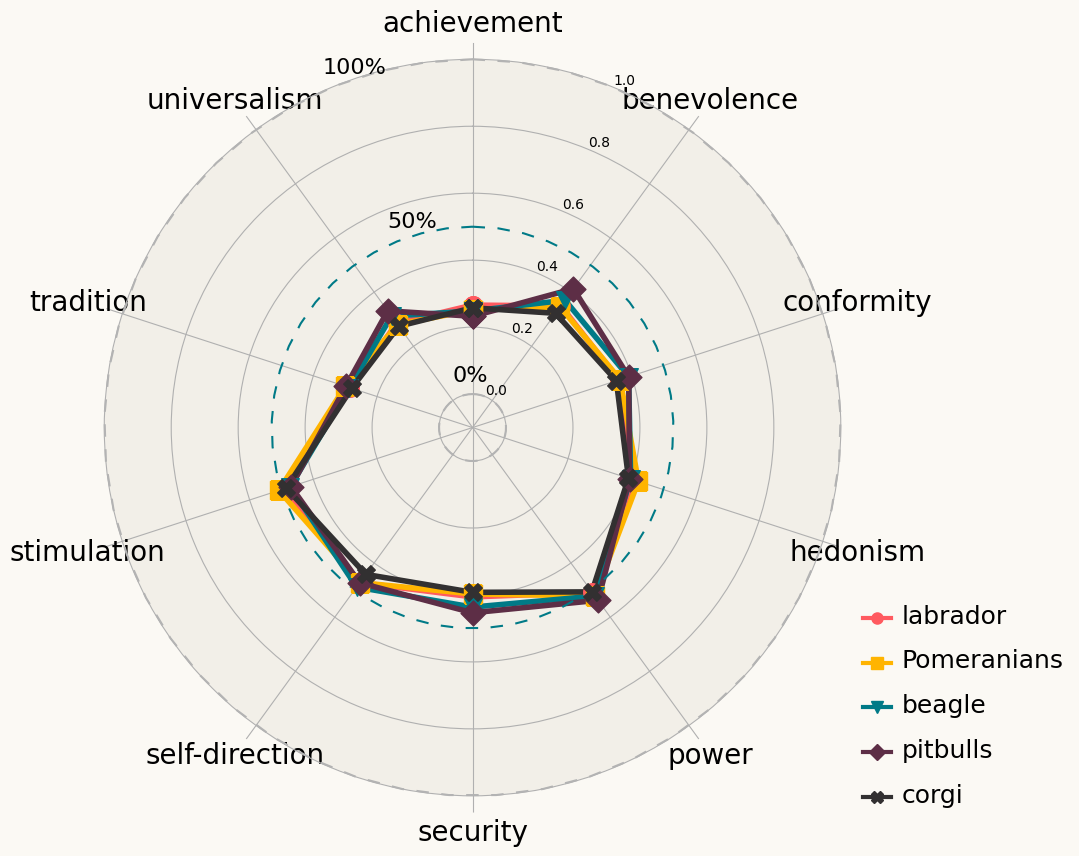

In [7]:
fig = plot_subreddits(subreddit_data, ['labrador', 'Pomeranians', "beagle", "pitbulls", "corgi"])
# fig.savefig('outputs/states.png', dpi=200, bbox_inches='tight')

In [41]:
value_similarities[0]

array([0.02788853, 0.00019915, 0.00440158, 0.01366329, 0.00106102,
       0.00273679, 0.01617036, 0.00752167, 0.02324426, 0.00183439])

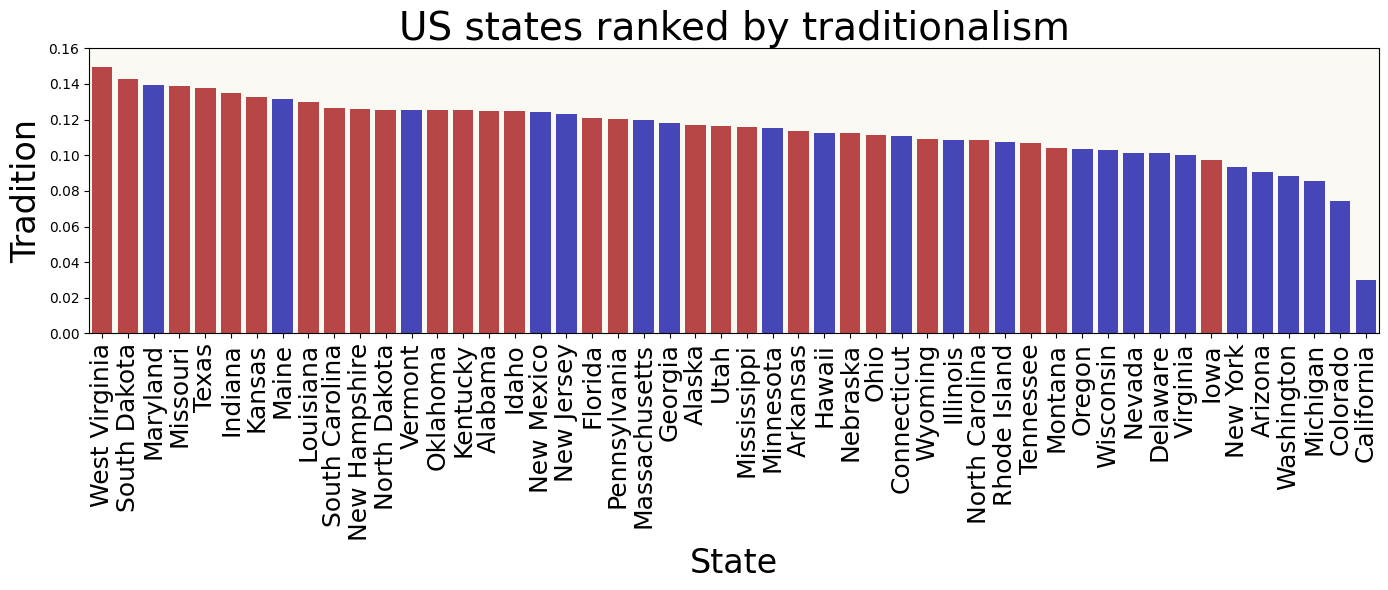

In [3]:
BG_WHITE = "#fbf9f4"
BLUE = "#2a475e"
GREY70 = "#b3b3b3"
GREY_LIGHT = "#f2efe8"

# rank states by traditionalism
possible_states = ["California", "arizona", "Texas", "Florida", "New York", "Pennsylvania", "Illinois", "Ohio", "Georgia", "North Carolina", "Michigan", "New Jersey", "Virginia", "Washington", "Arizona", "Massachusetts", "Tennessee", "Indiana", "Missouri", "Maryland", "Wisconsin", "Colorado", "Minnesota", "South Carolina", "Alabama", "Louisiana", "Kentucky", "Oregon", "Oklahoma", "Connecticut", "Utah", "Iowa", "Nevada", "Arkansas", "Mississippi", "Kansas", "New Mexico", "Nebraska", "West Virginia", "Idaho", "Hawaii", "New Hampshire", "Maine", "Montana", "Rhode Island", "Delaware", "South Dakota", "North Dakota", "Alaska", "Vermont", "Wyoming"]
possible_states += [state.lower() for state in possible_states]
possible_states += [state.upper() for state in possible_states]
possible_states += [state.title() for state in possible_states]
possible_states += [state.replace(" ", "") for state in possible_states]
possible_states += [state.replace(" ", "_") for state in possible_states]
possible_states += [state.replace(" ", "-") for state in possible_states]
possible_states = list(set(filter(lambda x: x in subreddit_data.index.tolist(), possible_states)))


state_values = subreddit_data.loc[possible_states]
state_values.sort_values(by="tradition", ascending=False, inplace=True)

all_states = ['Delaware', "Alabama", 'Georgia', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kentucky', 'Louisiana', 'Maine', 'Michigan', 'Montana', 'Nebraska', 'Nevada', 'NewMexico', 'NorthCarolina',"Arkansas", 'Ohio', 'Pennsylvania', 'RhodeIsland', 'SouthDakota', 'Tennessee', 'Utah', 'Virginia', 'Washington', 'WestVirginia', 'alaska', 'arizona', 'florida', 'illinois', 'kansas', 'maryland', 'massachusetts', 'minnesota', 'mississippi', 'missouri', 'newhampshire', 'newjersey', 'newyork', 'northdakota', 'oklahoma', 'oregon', 'southcarolina', 'texas', 'vermont', 'wisconsin', 'wyoming']
blue_states = ['arizona', 'Delaware', 'Georgia', 'Hawaii', 'illinois', 'Maine', 'maryland', 'Michigan', 'minnesota', 'Nevada', 'NewMexico', 'RhodeIsland', 'vermont', 'Virginia', 'wisconsin', 'California', 'Colorado', 'Connecticut', 'massachusetts', 'newjersey', 'newyork', 'oregon', 'pennsylvania', 'Washington']
red_states = [state for state in all_states if state not in blue_states]
red_states.sort()

map_sub_name_to_state = {"California": "California", "Colorado": "Colorado", "Connecticut": "Connecticut", "Alabama": "Alabama", "Delaware": "Delaware", "arizona": "Arizona", "Georgia": "Georgia", "Hawaii": "Hawaii", "Idaho": "Idaho", "Indiana": "Indiana", "Iowa": "Iowa", "Kentucky": "Kentucky", "Louisiana": "Louisiana", "Maine": "Maine", "Michigan": "Michigan", "Montana": "Montana", "Nebraska": "Nebraska", "Nevada": "Nevada", "NewMexico": "New Mexico", "NorthCarolina": "North Carolina", "Arkansas": "Arkansas", "Ohio": "Ohio", "Pennsylvania": "Pennsylvania", "RhodeIsland": "Rhode Island", "SouthDakota": "South Dakota", "Tennessee": "Tennessee", "Utah": "Utah", "Virginia": "Virginia", "Washington": "Washington", "WestVirginia": "West Virginia", "alaska": "Alaska", "arizona": "Arizona", "florida": "Florida", "illinois": "Illinois", "kansas": "Kansas", "maryland": "Maryland", "massachusetts": "Massachusetts", "minnesota": "Minnesota", "mississippi": "Mississippi", "missouri": "Missouri", "newhampshire": "New Hampshire", "newjersey": "New Jersey", "newyork": "New York", "northdakota": "North Dakota", "oklahoma": "Oklahoma", "oregon": "Oregon", "southcarolina": "South Carolina", "texas": "Texas", "vermont": "Vermont", "wisconsin": "Wisconsin", "wyoming": "Wyoming"}
colours = []
for state in state_values.index:
    if state in blue_states:
        # a nice blue
        colours.append((0.2,0.2,0.8))
    elif state in red_states:
        # a nice red
        colours.append((0.8,0.2,0.2))
    else:
        colours.append((0,0,0))
# using the same colour pallete as the radar plot from above

x = [map_sub_name_to_state[state] for state in state_values.index]
fig = plt.figure(figsize=(14, 6))
ax = sns.barplot(x=x, y=state_values["tradition"], palette=colours)
ax.set_ylabel("Tradition", fontsize=24)
ax.set_xlabel("State", fontsize=24)
ax.set_ylim(0, 0.16)
ax.set_title("US states ranked by traditionalism", fontsize=28)
plt.xticks(rotation=90)
ax.tick_params(axis='x', which='major', labelsize=18)
plt.tight_layout()
# set background color
plt.gca().patch.set_facecolor(BG_WHITE)
plt.savefig('outputs/states.png', dpi=200, bbox_inches='tight')

In [12]:
religious_states =  ["Alabama", "Mississippi", "Tennessee", "Louisiana", "Arkansas", "South Carolina", "West Virginia", "Georgia", "Oklahoma", "North Carolina", "Texas", "Utah", "Kentucky", "Virginia", "Missouri", "South Dakota", "Ohio", "New Mexico", "Iowa", "Kansas", "New Jersey", "Florida", "Indiana", "Maryland", "Nebraska", "Wyoming", "Arizona", "Michigan", "North Dakota", "Pennsylvania", "Delaware", "Idaho", "Illinois", "California", "Minnesota", "Nevada", "Rhode Island", "Montana", "Oregon", "Colorado", "Hawaii", "New York", "Alaska", "Washington", "Wisconsin", "Connecticut", "Maine", "Vermont", "Massachusetts", "New Hampshire"]
conservative_states = ["Massachusetts", "Delaware", "Maryland", "Rhode Island", "New Jersey", "New York", "Hawaii", "Oregon", "Vermont", "Washington", "California", "Illinois", "Colorado", "Connecticut", "Nevada", "Alaska", "Maine", "New Hampshire", "New Mexico", "Michigan", "Minnesota", "Pennsylvania", "Florida", "Oklahoma", "Arizona", "Kansas", "Missouri", "Texas", "Virginia", "North Carolina", "Ohio", "Indiana", "Iowa", "Nebraska", "Wisconsin", "Wyoming", "Arkansas", "Georgia", "Idaho", "Kentucky", "South Carolina", "Montana", "Mississippi", "North Dakota", "Utah", "Tennessee", "South Dakota", "West Virginia", "Alabama", "Louisiana"]

In [26]:
to_corr = []
for state in x[::-1]:
    to_corr.append(conservative_states.index(state))
    

In [21]:
state

'California'

In [27]:
spearmanr(to_corr, range(len(to_corr)))

SpearmanrResult(correlation=0.3040096038415366, pvalue=0.031841927161772914)